# Blurred Ball Cover

In [237]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import random
from collections import namedtuple
import numpy.linalg as npl
from sets import Set

In [238]:
Ball = namedtuple("Ball", ["center", "radius"])
BlurredBall = namedtuple("BlurredBall", ["k", "MEB"])

In [239]:
def approx_meb(points, epsilon):
    coreset = []
    num_of_points = len(points)
    furthest_point = None
    center = points[0]
    #print("Points: ", points)
    #print("Initial Center: " , points[0][0], points[0][1])
    num_iterations = int(1.0 / (epsilon * epsilon))
    #num_iterations = 1000
    #print("Number of Iterations: " + repr(num_iterations))
    distances = {}

    prev_radius = -10000.0
    
    for i in range(1, num_iterations):
        #print("Iteration: ", i)
        for j in range(num_of_points):
            distances[j] = npl.norm(points[j] - center)
        furthest_point_index = max(distances, key = distances.get)
        furthest_point = points[furthest_point_index]
        furthest_distance = distances[furthest_point_index]

        center = center + (1.0 / i) * (furthest_point - center)

        if abs(furthest_distance - prev_radius) < 0.01:
            break
            
    for point in points:
        if abs(npl.norm(point - center) - furthest_distance) < 0.01:
            coreset.append(point)
            
    radius = npl.norm(furthest_point - center)
    blurred_ball = BlurredBall(coreset, Ball(center, radius))
    return blurred_ball

In [240]:
def generate_normal_data(num_of_points, num_of_dimensions):
    mean = random.sample(np.array(range(100)), num_of_dimensions)
    scalar_variances = 10.0 * np.ones(num_of_dimensions)
    covariance = np.diag(scalar_variances)
    points = np.random.multivariate_normal(mean, covariance, num_of_points)
    return points

def generate_multivariate_data(num_of_points, num_of_dimensions):
    probabilities = [float(1.0 / num_of_dimensions)] * num_of_dimensions
    points = np.random.multinomial(20, probabilities, size = num_of_points)
    return points


In [248]:
def inside_ball_eps(blurred_ball, point, epsilon):
    #print "inside_ball"
    center, radius = blurred_ball.MEB
    distance = npl.norm(point - center)
    if distance <= (1 + epsilon) * radius:
        return True
    else:
        return False

In [249]:
def update(blurred_balls, A, epsilon):
    print "update"
    K = []
    for blurred_ball in blurred_balls:
        K.extend(blurred_ball.k)


    outer_loop_flag = False    
    for point in A:
        if outer_loop_flag == True:
            break
        for blurred_ball in blurred_balls:
            if inside_ball_eps(blurred_ball, point, epsilon) == False:
                outer_loop_flag = True
                break
                
    if outer_loop_flag == False:
        #print("This point is covered")
        return blurred_balls
    #else:
        #print("This point is not covered")
        
    K_union_A = list(K)
    K_union_A.extend(A)
    blurred_ball_new = approx_meb(K_union_A, epsilon / 3.0)
    
    discardables = []
    for blurred_ball in blurred_balls:
        lhs = blurred_ball.MEB.radius
        rhs = epsilon * blurred_ball_new.MEB.radius / 4.0
        #print("lhs <> rhs: " + repr(lhs) + " <> " + repr(rhs))
        if blurred_ball.MEB.radius <= (epsilon * blurred_ball_new.MEB.radius / 4.0):
            print "Found a discardable"
            discardables.append(blurred_ball)
    
    blurred_balls = [bb for bb in blurred_balls if bb not in discardables]
    
    blurred_balls.append(blurred_ball_new)
    
    return blurred_balls
        

In [255]:
def agarwal(points, num_of_points, num_of_dimensions, epsilon):
    #epsilon = 0.1
    batch_size = 50
    blurred_balls = []
    initial_points = points[0:num_of_dimensions, :]
    blurred_ball_init = approx_meb(initial_points, epsilon / 3.0)
    blurred_balls = [blurred_ball_init]

    for i in range(num_of_dimensions, num_of_points, batch_size):
        print "Iteration: " + repr(i)
        sid = i
        fid = min(i + batch_size, num_of_points)
        A = points[sid : fid, :]
        blurred_balls = update(blurred_balls, A, epsilon)
        
    return blurred_balls
  

In [251]:
def draw_blurred_balls(blurred_balls):
    xmin = min(points[:, 0])
    xmax = max(points[:, 0])
    ymin = min(points[:, 1])
    ymax = max(points[:, 1])

    print(xmin, xmax, ymin, ymax)
    # ball <- \phi
    ball = None
    count = 0
    processed_points = []
    fig, ax = plt.subplots(1, 1) 
    #ax.set_xlim(xmin - 10, xmax + 10)
    #ax.set_ylim(ymin - 10, ymax + 10)
    ax.set_aspect('equal', 'datalim')
    ax.set_xlim(xmin - 10, xmax + 10)
    ax.set_ylim(ymin - 10, ymax + 10)


    X = points[:, 0]
    Y = points[:, 1]
    scatters = plt.scatter(X, Y)

    for blurred_ball in blurred_balls:
        center, radius = blurred_ball.MEB
        circle = plt.Circle(center, radius, color='r', alpha = 0.1)
        ax.add_artist(circle)
        ax.add_artist(scatters)

Iteration: 2
update
Iteration: 52
update
Iteration: 102
update
Iteration: 152
update
Iteration: 202
update
Iteration: 252
update
Iteration: 302
update
Iteration: 352
update
Iteration: 402
update
Iteration: 452
update
Iteration: 502
update
Iteration: 552
update
Iteration: 602
update
Iteration: 652
update
Iteration: 702
update
Iteration: 752
update
Iteration: 802
update
Iteration: 852
update
Iteration: 902
update
Iteration: 952
update
(4.0995220644590677, 28.723212564647042, 32.443584557623481, 53.706333501647983)


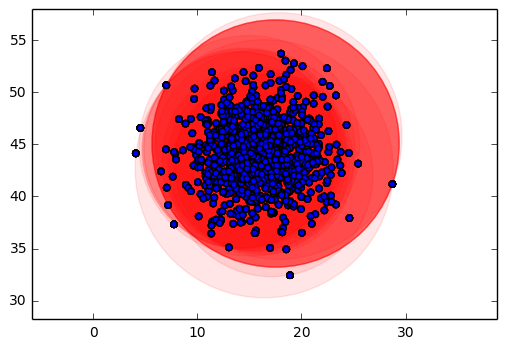

In [256]:
num_of_points = 1000
num_of_dimensions = 2
points = generate_normal_data(num_of_points, num_of_dimensions)
blurred_balls = agarwal(points, num_of_points, num_of_dimensions, 0.1)
draw_blurred_balls(blurred_balls)

In [ ]:
blurred_balls = agarwal(points, num_of_points, num_of_dimensions, 0.01)
draw_blurred_balls(blurred_balls)

# Timothy Chan's Algorithm

In [ ]:
Ball = namedtuple("Ball", ["center", "radius"])

def inside_ball(ball, point):
    center, radius = ball
    distance = npl.norm(point - center)
    if distance < radius:
        return True
    else:
        return False

def meb_ball_and_point(ball, p):
    c, r = ball
    pc_scalar = npl.norm(c - p)
    pc_vector = c - p
    radius_unit = pc_vector / pc_scalar
    p_mirror = radius_unit * r + c
    c_prime = (p + p_mirror) / 2.0
    r_prime = npl.norm(p_mirror - p) / 2.0
    meb = Ball(c_prime, r_prime)
    return meb

def create_initial_ball(point):
    return Ball(point, 0.0)

def chan(points):
    xmin = min(points[:, 0])
    xmax = max(points[:, 0])
    ymin = min(points[:, 1])
    ymax = max(points[:, 1])

    print(xmin, xmax, ymin, ymax)
    # ball <- \phi
    ball = None
    count = 0
    processed_points = []
    fig, ax = plt.subplots(1, 1) 
    #ax.set_xlim(xmin - 10, xmax + 10)
    #ax.set_ylim(ymin - 10, ymax + 10)
    ax.set_aspect('equal', 'datalim')
    ax.set_xlim(xmin - 10, xmax + 10)
    ax.set_ylim(ymin - 10, ymax + 10)

    for point in points:
        processed_points.append(point)

        if ball == None:
            ball = create_initial_ball(point)
            print("Ball: ", ball)
            continue
        if inside_ball(ball, point):
            continue
        else:
            count += 1
            ball = meb_ball_and_point(ball, point)
            center, radius = ball
            print("radius: ", radius)

            circle = plt.Circle(center, radius, color='r', alpha = 0.1)
            pp = np.array(processed_points)
            X = pp[:, 0]
            Y = pp[:, 1]
            plt.scatter(X, Y)

            ax.add_artist(circle)
            ax.add_artist(scatters)
            #plt.show()
            fig.savefig('plotcircles' + repr(count) + '.png')
    

(33.089887691629556, 54.150571796262938, 44.04589591640265, 68.77739943817221)
('Ball: ', Ball(center=array([ 45.92964893,  59.294779  ]), radius=0.0))
('radius: ', 3.2250646752402012)
('radius: ', 4.5279447899111638)
('radius: ', 5.7588587505147535)
('radius: ', 6.7119937582086449)
('radius: ', 6.724963867644882)
('radius: ', 8.5083420155525662)
('radius: ', 8.9401373557356738)
('radius: ', 9.6218479891433439)
('radius: ', 10.112737855256611)
('radius: ', 10.168618429353705)
('radius: ', 10.500610737932103)
('radius: ', 10.632486001686074)
('radius: ', 10.892580077094092)
('radius: ', 12.977760897913591)


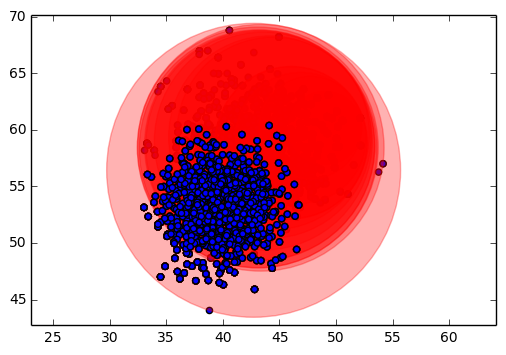

In [254]:
    
    
chan(points)
    